This notebook explores three experimental setups using two top-performing machine learning models—Logistic Regression and Linear SVM—based on prior results. It also includes code for unigram extraction and visualization, and error analysis section.

Make sure to check and correct the file paths if needed.

In [116]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
import numpy as np
import pandas as pd

## Load datasets
**Final datasets:**

1. Train split: cleaned, normalized by length distribution.
   
   - class 0 - human texts
   - class 1 - 100% AI generated texts

2. Test split n1: cleaned, not normalized.
   - class 0 - human texts
   - class 1 - 100% AI generated texts

3. Test split n2: cleaned, not normalized.
   - class 0 - human texts
   - class 1 - 100% AI generated texts for 'poems' and 'social' (media) genres
   - class 1 for genre 'news' - edited 'mixed' texts

4. Test split n3: cleaned, not normalized.
   - class 0 - human texts
   - class 1 - 100% AI generated texts for 'poems' and 'social' (media) genres
   - class 1 for genre 'news' - 'humanized' with Decopy AI and edited with the focus on n-grams (see later in the notebook)

In [117]:
# Make sure to correct the file paths if needed!
# load the cleaned train split
df_train = pd.read_csv("data/final/train_split.csv")
df_train.sample(5)

,texts,source,word_counts,genre,class
1898,Куда ни посмотри — везде одна показуха. А реал...,chatgpt-4o-latest,23,social,1
1899,"вот пишут ""сырое мясо полезно для кошек, это и...",chatgpt-4o-latest,42,social,1
133,"На смерть NN\nГонители, он — ваш! Вам плески и...",Денис Васильевич Давыдов,31,poems,0
27,Е. О. Лихачевой («Уезжая в страну равноправную...,Некрасов Николай Алексеевич,89,poems,0
1051,"На Ютуб есть много видео, как посадить и как у...",pikabu,34,social,0


In [118]:
df_train['genre'].value_counts()

,count
genre,
poems,800
news,800
social,800


In [119]:
# load the test split for set up n1.
# human and fully ai generated texts for all genres
df_test_1 = pd.read_csv("data/final/test_split_1.csv")
df_test_1.sample(5)

,texts,source,word_counts,genre,class
36,1\. 2-4 тыс. в Израиле это после налогов?\n2\....,pikabu,77.0,social,0
381,"На позитиве\nРекордная выручка, прибыль, налог...",lenta.ru,1894.0,news,0
292,Стихи на объявление памятника историографу Н.М...,Николай Михайлович Языков,693.0,poems,0
471,Засохшая береза\nВ глуши на почве раскаленной\...,Иван Саввич Никитин,77.0,poems,0
190,Парус\nБелеет парус одинокой\nВ тумане моря го...,Лермонтов Михаил Юрьевич,58.0,poems,0


In [120]:
df_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   texts        600 non-null    object 
 1   source       600 non-null    object 
 2   word_counts  600 non-null    float64
 3   genre        600 non-null    object 
 4   class        600 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 23.6+ KB


In [121]:
# load the test split for set up n2.
# Texts of news genre are replaced by edited 'mixed' texts.
# Class remains 1 for the 'mixed' texts.

df_test_2 = pd.read_csv("data/final/test_split_2.csv")
df_test_2.sample(5)

,texts,source,word_counts,genre,class
504,"Ну конечно, очередной предвор в твиттере разво...",chatgpt-4o-latest,34.0,social,1
318,Опять весна! Опять какой-то гений…\nОпять весн...,Алексей Николаевич Апухтин,196.0,poems,0
464,Цицерон\nОратор римский говорил\nСредь бурь гр...,Тютчев Федор Иванович,73.0,poems,0
332,Новый всплеск гриппа зафиксирован в Красноярск...,mixed,NaN,news,1
372,"потому что третья рука ""мифическая"",как ""трети...",pikabu,42.0,social,0


In [122]:
# load the test split for set up n3.
# 50 texts of news genre are replaced by 'humanized' texts.
# 51 texts of news genre are edited with the focus on N-grams obtained in this notebook.
# Class remains 1 for the 'humanized' and edited 'n_gram' texts.

df_test_3 = pd.read_csv("data/final/test_split_3.csv")
df_test_3.sample(5)

,texts,source,word_counts,genre,class
298,США захотели новую ракету за два с половиной б...,lenta.ru,346.0,news,0
465,День народного единства: история и современнос...,n_grams,NaN,news,1
370,"Ну вот, чтобы не было конкуренции Яблоко и отк...",fb,19.0,social,0
564,"Павел Котов Михаил Касьянов, член КПСС 1978–19...",fb,7.0,social,0
348,Премьер-министр Армении обсудил ситуацию в рег...,n_grams,NaN,news,1


In [123]:
df_test_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   texts        600 non-null    object 
 1   source       600 non-null    object 
 2   word_counts  499 non-null    float64
 3   genre        600 non-null    object 
 4   class        600 non-null    int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 23.6+ KB


In [124]:
# 50 texts 'humanized' by decopy AI
# 51 edited with the focus on n_grams
df_test_3[df_test_3['genre'] == 'news']['source'].value_counts()

,count
source,
n_grams,51
decopy-ai,50
lenta.ru,40
meduza.io,30
ria.ru,29


## Baseline with classical ML algorithms

- Input - texts
- Output - predicted lables

**Set up n1:**
We use the train split and check the classifier on test split n1.  

**Set up n2:**
We will use the same classifier on the test split n2, where AI-generated news texts were replaced by the edited 'mixed' texts.

**Set up n3:**
We will use the same classifier on the test split n3, where AI-generated news texts were replaced by the edited 'n_grams' and 'humanized' texts from DecopyAI.

In [125]:
# Let's define X and y for the training set

X_train = df_train['texts']
y_train = df_train['class']

# Check the shape of the training data
X_train.shape, y_train.shape

((2400,), (2400,))

In [126]:
# Define X and y for the test set n1

X_test_1 = df_test_1['texts']
y_test_1 = df_test_1['class']

X_test_1.shape, y_test_1.shape

((600,), (600,))

In [127]:
# Define X and y for the test set n2

X_test_2 = df_test_2['texts']
y_test_2 = df_test_2['class']

X_test_2.shape, y_test_2.shape

((600,), (600,))

In [128]:
# Define X and y for the test set n3

X_test_3 = df_test_3['texts']
y_test_3 = df_test_3['class']

X_test_3.shape, y_test_3.shape

((600,), (600,))

### Logistic Regression

In [129]:
# First we set up a pipeline with default parameters

t_scaler = MaxAbsScaler()
vect = TfidfVectorizer(analyzer='word')
logreg = LogisticRegression(random_state=42)

pipeline_lg = Pipeline([
    ('tfidf', vect),
    ('scaler', t_scaler),
    ('clf', logreg)
])

pipeline_lg.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('scaler', MaxAbsScaler()),
                ('clf', LogisticRegression(random_state=42))])

#### Set up N1

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       297
           1       0.93      0.94      0.93       303

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



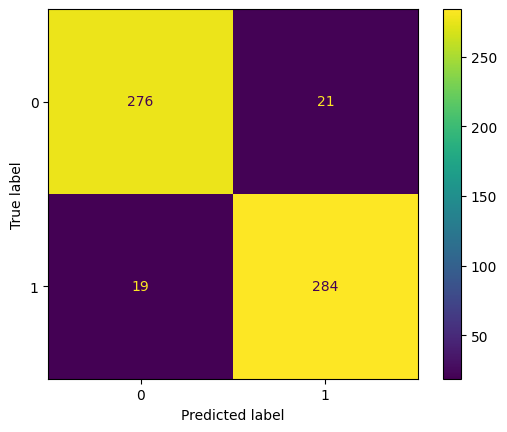

In [130]:
# Test the model on the first test split
y_test_pred_1 = pipeline_lg.predict(X_test_1)
print(classification_report(y_test_1, y_test_pred_1))
ConfusionMatrixDisplay.from_predictions(y_test_1, y_test_pred_1);

In [131]:
# This cell takes about 7 min to run!
# Parameter Optimization Step

param_grid = {
    'tfidf__analyzer': ['word', 'char'],
    'tfidf__ngram_range': [(1, 1), (2, 4), (3, 5)],
}

gs = GridSearchCV(pipeline_lg, param_grid, cv=10, scoring='f1_macro')
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('scaler', MaxAbsScaler()),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             param_grid={'tfidf__analyzer': ['word', 'char'],
                         'tfidf__ngram_range': [(1, 1), (2, 4), (3, 5)]},
             scoring='f1_macro')

In [132]:
print("Best parameters:", gs.best_params_)
print("Best cross-validation score:", gs.best_score_)

Best parameters: {'tfidf__analyzer': 'char', 'tfidf__ngram_range': (3, 5)}
Best cross-validation score: 0.9519269712431064


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       297
           1       0.99      0.96      0.97       303

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



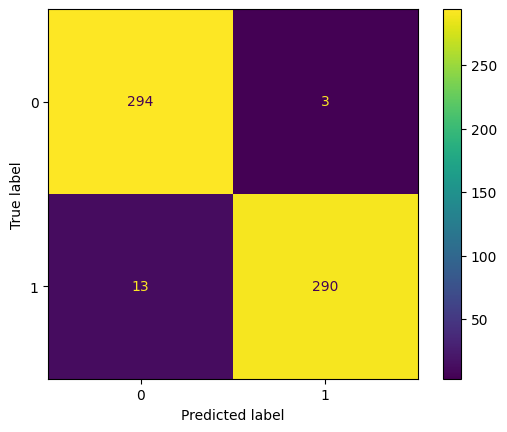

In [133]:
# Set up n1 - best result
y_gs_pred_1 = gs.predict(X_test_1)

print(classification_report(y_test_1, y_gs_pred_1))
ConfusionMatrixDisplay.from_predictions(y_test_1, y_gs_pred_1);

# Save to file
plt.savefig("plots/confusion_matrix_setup_1_lg.png", dpi=300, bbox_inches='tight')

In [134]:
# Function to create a df for error analysis
def get_error_df(df_test, y_true, y_pred):
    """Return a dataframe with misclassified samples and predicted labels."""
    mask = y_true != y_pred
    df_errors = df_test[mask].copy()
    df_errors['predicted_label'] = y_pred[mask]
    return df_errors

In [135]:
df_errors_1 = get_error_df(df_test_1, y_test_1, y_gs_pred_1)

In [136]:
df_errors_1['genre'].value_counts()

,count
genre,
social,15
news,1


In [137]:
news_rows_1 = df_errors_1[df_errors_1['genre'] == 'news']
news_rows_1.head()

,texts,source,word_counts,genre,class,predicted_label
358,Оппозиционер Алексей Навальный выписан из боль...,chatgpt-4o-latest,297.0,news,1,0


In [138]:
# Save to file (test split 1)
df_errors_1.to_csv("data/errors_setup_1_lg.csv", index=False)

#### Set up N2 - mixed texts

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       297
           1       0.99      0.95      0.97       303

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



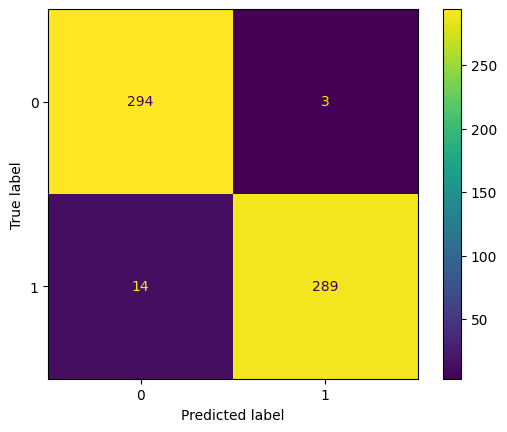

In [139]:
# Use the same classifier on test split n2
y_gs_pred_2 = gs.predict(X_test_2)

print(classification_report(y_test_2, y_gs_pred_2))
ConfusionMatrixDisplay.from_predictions(y_test_2, y_gs_pred_2);

# Save to file
plt.savefig("plots/confusion_matrix_setup_2_lg.png", dpi=300, bbox_inches='tight')

In [140]:
df_errors_2 = get_error_df(df_test_2, y_test_2, y_gs_pred_2)

In [141]:
df_errors_2['genre'].value_counts()

,count
genre,
social,15
news,2


In [142]:
# We were able to 'fool' the model only in 2/101 cases.
# Strictly speaking, the text 358 was already classified as human before my editing, so just 1/101.

news_rows_2 = df_errors_2[df_errors_2['genre'] == 'news']
news_rows_2.head()

,texts,source,word_counts,genre,class,predicted_label
273,Великобритания заявила о новых санкциях против...,mixed,NaN,news,1,0
358,Алексей Навальный выписан из больницы после от...,mixed,NaN,news,1,0


In [143]:
# Save to file (test split 2)
df_errors_2.to_csv("data/errors_setup_2_lg.csv", index=False)

#### LogReg Coefficients Explanation

We'd like to see what words are percieved as idicative of one class or another by the model.

In [144]:
def extract_top_features(model, top_n=60, class_labels={0: 'Human-generated', 1: 'AI-generated'}):
    """
    Displays the top indicative features for each class from a trained text classification pipeline.

    This function is designed for pipelines that include a TF-IDF vectorizer and a logistic regression classifier.
    It extracts and prints the most influential features (i.e., words or n-grams) that contribute to each class.

    Parameters:
    model : sklearn.pipeline.Pipeline or sklearn.model_selection.GridSearchCV
        A trained pipeline containing 'tfidf' and 'clf' steps. If GridSearchCV is passed, the best estimator is used.
    top_n : int, default=60
        The number of top features to display for each class.
    class_labels : dict, default={0: 'Human-generated', 1: 'AI-generated'}
        A dictionary mapping class indices (0 and 1) to human-readable labels.
    """

    if hasattr(model, 'best_estimator_'):
        model = model.best_estimator_

    vectorizer = model.named_steps['tfidf']
    clf_logreg = model.named_steps['clf']

    features = vectorizer.get_feature_names_out()

    coef = clf_logreg.coef_[0]

    # Top features
    top_class1_indices = np.argsort(coef)[-top_n:][::-1]
    top_class0_indices = np.argsort(coef)[:top_n]

    print(f"Chosen analyzer: {vectorizer.analyzer}")
    print(f"Chosen ngram range: {vectorizer.ngram_range}")
    print(f"Number of features: {len(features)}")

    print(f"\nTop indicative features for {class_labels[1]} (class = 1):")
    print(features[top_class1_indices])

    print(f"\nTop indicative features for {class_labels[0]} (class = 0):")
    print(features[top_class0_indices])

In [145]:
# The model after gridsearch was slightly better, but character-based features are not likely to be very helpful for interpreting the results.
extract_top_features(gs)

Chosen analyzer: char
Chosen ngram range: (3, 5)
Number of features: 412943

Top indicative features for AI-generated (class = 1):
[' а ' ', а ' ', а' 'т, ' ' но' 'а. ' ', к' ', чт' ', что' ', ч' '. н'
 'й. ' ' но ' ' как ' ', как' 'кто' ', ка' 'ечн' '. о' 'я, ' ' ка' 'а у'
 ' где' ' под' '-то ' ' ве' ', но ' ' вет' 'чер' '-то' 'е, ' ', но' ' нов'
 ' гд' ' где ' 'све' '. ну ' ' как' '. ну' 'чере' 'дь ' '. «' '. с' 'й, '
 'как ' '. в' 'свет' ', где' ', гд' ' ста' ', а н' 'ют, ' 'ся, ' 'жит'
 'бсу' 'а у ' 'ы. ' ' а н' 'а, ' 'ают']

Top indicative features for Human-generated (class = 0):
['\nи ' 'не ' ' не' ' - ' ' ер' ',\nк' 'ири' '\nно' '\nпо' 'един' ' он'
 ',\nи' ' ед' '.\nс' 'при' ',\nв' ' ро' '\nв ' 'о по' 'оро' '\nна' 'ов '
 '\nно ' 'а.\n' ',\nн' 'ее ' 'а,\n' ' —\n' 'е,\n' '", - ' '", -' 'жири'
 ' кп' '\nза' ',\nи ' 'жир' ',\nп' 'при ' 'кпр' 'и,\n' ' от' 'дин' 'ино'
 'а е' 'й,\n' '.\nо' ', - ' ', -' ' ер ' 'кпрф' 'прф' 'они' 'осс' 'росс'
 ' жир' '.\nи' 'в то' ' и ' ' еди' 'ии ']


In [146]:
# Extract top features from the first classifier trained with a 'word' based vectorizer
extract_top_features(pipeline_lg)

Chosen analyzer: word
Chosen ngram range: (1, 1)
Number of features: 53477

Top indicative features for AI-generated (class = 1):
['как' 'где' 'кто' 'всё' 'почему' 'свет' 'теперь' 'ведь' 'потом' 'уже'
 'ну' 'снова' 'зато' 'каждый' 'будто' 'опять' 'про' 'стоит' 'обещания'
 'новый' 'такие' 'тени' 'ветер' 'словно' 'шепчет' 'ветра' 'никто' 'что'
 'очередной' 'просто' 'звезды' 'нас' 'только' 'кажется' 'однако' 'лица'
 'вчера' 'продолжают' 'чтобы' 'хоть' 'итоге' 'новые' 'путь' 'напомним'
 'ещё' 'вдали' 'цирк' 'вечный' 'чайник' 'конечно' 'через' 'лишь' 'но'
 'толку' 'могли' 'когда' 'интересно' 'жить' 'эксперты' 'пока']

Top indicative features for Human-generated (class = 0):
['ер' 'не' 'при' 'кпрф' 'россии' 'том' 'есть' 'он' 'года' 'ее' 'мне' 'риа'
 'лдпр' 'много' 'от' 'они' 'было' 'жириновский' 'поэтому' 'единая'
 'коронавируса' 'ты' 'едро' 'после' 'жирик' 'надо' 'очень' 'партии'
 'сказал' 'рф' 'во' 'стопкоронавирус' 'первый' 'россию' 'того' 'парнас'
 'ль' 'сша' 'именно' 'меня' 'единой' 'мо

In [147]:
# To make more sense of the unigrams, we'd like to check what bigrams might be important for prediction.
# This classifier will most likely show worse results than the previous ones.
t_scaler = MaxAbsScaler()
vect = TfidfVectorizer(analyzer='word', ngram_range=(2, 3))
logreg = LogisticRegression(random_state=42)

pipeline_lg_2 = Pipeline([
    ('tfidf', vect),
    ('scaler', t_scaler),
    ('clf', logreg)
])

pipeline_lg_2.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(2, 3))),
                ('scaler', MaxAbsScaler()),
                ('clf', LogisticRegression(random_state=42))])

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       297
           1       0.85      0.85      0.85       303

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



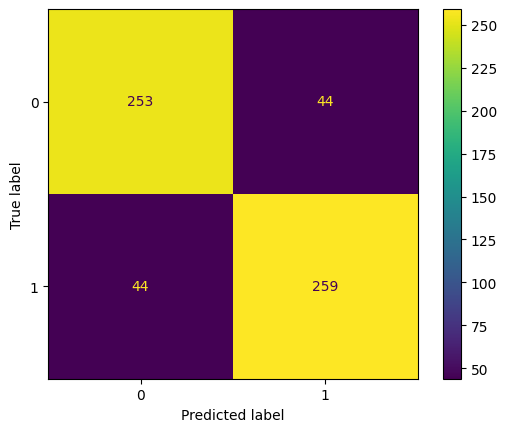

In [148]:
y_test_pred_1_bigrams = pipeline_lg_2.predict(X_test_1)
print(classification_report(y_test_1, y_test_pred_1_bigrams))
ConfusionMatrixDisplay.from_predictions(y_test_1, y_test_pred_1_bigrams);

In [149]:
extract_top_features(pipeline_lg_2)

Chosen analyzer: word
Chosen ngram range: (2, 3)
Number of features: 481051

Top indicative features for AI-generated (class = 1):
['как будто' 'где то' 'кто то' 'кто нибудь' 'что то' 'на деле'
 'как всегда' 'может пора' 'ну конечно' 'никто не' 'когда уже' 'всё как'
 'каждый раз' 'ну вот' 'те же лица' 'же лица' 'да уж' 'вот это' 'там где'
 'ну что' 'ветер шепчет' 'не только' 'вы заметили' 'те же' 'нас тут'
 'как обычно' 'свет луны' 'все эти' 'где тени' 'одно то' 'одно то же'
 'заметили как' 'по словам' 'где звезды' 'цены растут' 'ну всё'
 'это просто' 'сколько можно' 'напомним что' 'на месте' 'кажется что'
 'главное чтобы' 'нас всё' 'но сердце' 'каждый день' 'как говорится'
 'отмечают что' 'могли бы' 'потом удивляются' 'как свет' 'вы заметили как'
 'кто громче' 'чайник подсветкой 1800' 'подсветкой 1800' 'меня чайник'
 'меня чайник подсветкой' 'чайник подсветкой' 'подсветкой 1800 вт'
 '1800 вт' 'бы еще картинку']

Top indicative features for Human-generated (class = 0):
['единой россии'

**Plots**

In [150]:
pip install wordcloud matplotlib

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
import urllib.request

In [152]:
# Modified function to extract unigrams and their weights for Word Cloud Plotting

def extract_top_features(model, top_n=60, class_labels={0: 'Human-generated', 1: 'AI-generated'}):

    if hasattr(model, 'best_estimator_'):
        model = model.best_estimator_

    vectorizer = model.named_steps['tfidf']
    clf_logreg = model.named_steps['clf']

    features = vectorizer.get_feature_names_out()
    coef = clf_logreg.coef_[0]

    # Sort indices for top positive and negative coefficients
    top_class1_indices = np.argsort(coef)[-top_n:][::-1]  # class 1: most positive
    top_class0_indices = np.argsort(coef)[:top_n]         # class 0: most negative

    print(f"Chosen analyzer: {vectorizer.analyzer}")
    print(f"Chosen ngram range: {vectorizer.ngram_range}")
    print(f"Number of features: {len(features)}")

    print(f"\nTop indicative features for {class_labels[1]} (class = 1):")
    print(features[top_class1_indices])

    print(f"\nTop indicative features for {class_labels[0]} (class = 0):")
    print(features[top_class0_indices])

    # Return features with weights for word clouds
    top_class1_features = {features[i]: coef[i] for i in top_class1_indices}
    top_class0_features = {features[i]: -coef[i] for i in top_class0_indices}  # flip to positive for display

    return top_class1_features, top_class0_features

In [153]:
ai_words, human_words = extract_top_features(pipeline_lg)

Chosen analyzer: word
Chosen ngram range: (1, 1)
Number of features: 53477

Top indicative features for AI-generated (class = 1):
['как' 'где' 'кто' 'всё' 'почему' 'свет' 'теперь' 'ведь' 'потом' 'уже'
 'ну' 'снова' 'зато' 'каждый' 'будто' 'опять' 'про' 'стоит' 'обещания'
 'новый' 'такие' 'тени' 'ветер' 'словно' 'шепчет' 'ветра' 'никто' 'что'
 'очередной' 'просто' 'звезды' 'нас' 'только' 'кажется' 'однако' 'лица'
 'вчера' 'продолжают' 'чтобы' 'хоть' 'итоге' 'новые' 'путь' 'напомним'
 'ещё' 'вдали' 'цирк' 'вечный' 'чайник' 'конечно' 'через' 'лишь' 'но'
 'толку' 'могли' 'когда' 'интересно' 'жить' 'эксперты' 'пока']

Top indicative features for Human-generated (class = 0):
['ер' 'не' 'при' 'кпрф' 'россии' 'том' 'есть' 'он' 'года' 'ее' 'мне' 'риа'
 'лдпр' 'много' 'от' 'они' 'было' 'жириновский' 'поэтому' 'единая'
 'коронавируса' 'ты' 'едро' 'после' 'жирик' 'надо' 'очень' 'партии'
 'сказал' 'рф' 'во' 'стопкоронавирус' 'первый' 'россию' 'того' 'парнас'
 'ль' 'сша' 'именно' 'меня' 'единой' 'мо

In [155]:
# Download a font that supports Cyrillic
font_url = "https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSans/NotoSans-Regular.ttf"
font_path = "/tmp/NotoSans-Regular.ttf"
urllib.request.urlretrieve(font_url, font_path)

('/tmp/NotoSans-Regular.ttf', <http.client.HTTPMessage at 0x783c6e7268d0>)

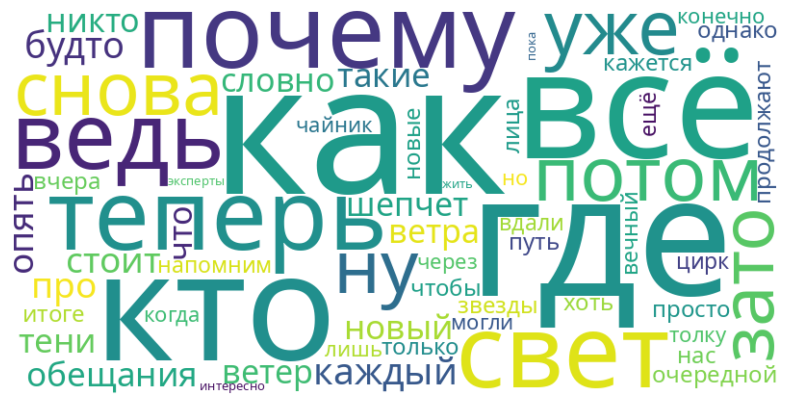

In [156]:
# Generate the word clouds from frequency dictionaries for Class 1
ai_wc = WordCloud(width=800, height=400, background_color='white', font_path=font_path)
ai_wc.generate_from_frequencies(ai_words)

plt.figure(figsize=(10, 5))
plt.imshow(ai_wc, interpolation='bilinear')
plt.axis('off')
#plt.title('AI-generated Text Unigrams', fontsize=16) looks better without a title
plt.show()

# Correct the file path and save to file if needed
ai_wc.to_file("plots/ai_wordcloud.png")

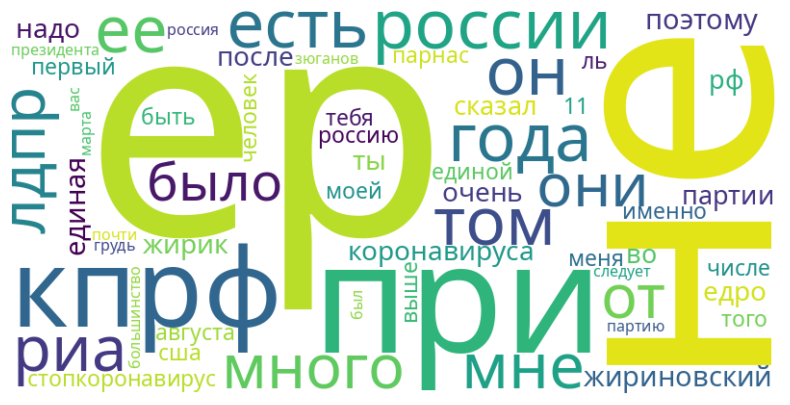

In [157]:
human_wc = WordCloud(width=800, height=400, background_color='white', font_path=font_path)
human_wc.generate_from_frequencies(human_words)

plt.figure(figsize=(10, 5))
plt.imshow(human_wc, interpolation='bilinear')
plt.axis('off')
#plt.title('Human-generated Text Unigrams', fontsize=16)
plt.show()

# Save to file if needed
human_wc.to_file("plots/human_wordcloud.png")

In [198]:
def plot_class_unigrams(ai_dict, human_dict, top_n=30):
    """
    Creates a vertical mirrored bar plot for Class 1.
    Green: Top features for class 1.
    Red: Top anti-features (most indicative of Class 0).

    Args:
        ai_dict (dict): Top class 1 features with positive weights
        human_dict (dict): Top class 0 features with flipped positive weights
        top_n (int): Number of top features to show in each direction
    """
    # Take top_n from each dictionary
    top_ai_items = sorted(ai_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_human_items = sorted(human_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Prepare words and weights
    words = [item[0] for item in top_human_items] + [item[0] for item in top_ai_items]
    weights = [-item[1] for item in top_human_items] + [item[1] for item in top_ai_items]
    colors = ['red'] * top_n + ['green'] * top_n

    # Plot
    x = np.arange(len(words))
    plt.figure(figsize=(18, 6))
    plt.bar(x, weights, color=colors)
    plt.axhline(0, color='black')
    plt.xticks(x, words, rotation=65, ha='right')
    plt.title("Top 30 Unigrams for Class 1")
    plt.tight_layout()

    # Save to file
    plt.savefig("plots/class1_unigrams.png", dpi=300, bbox_inches='tight')
    plt.show()

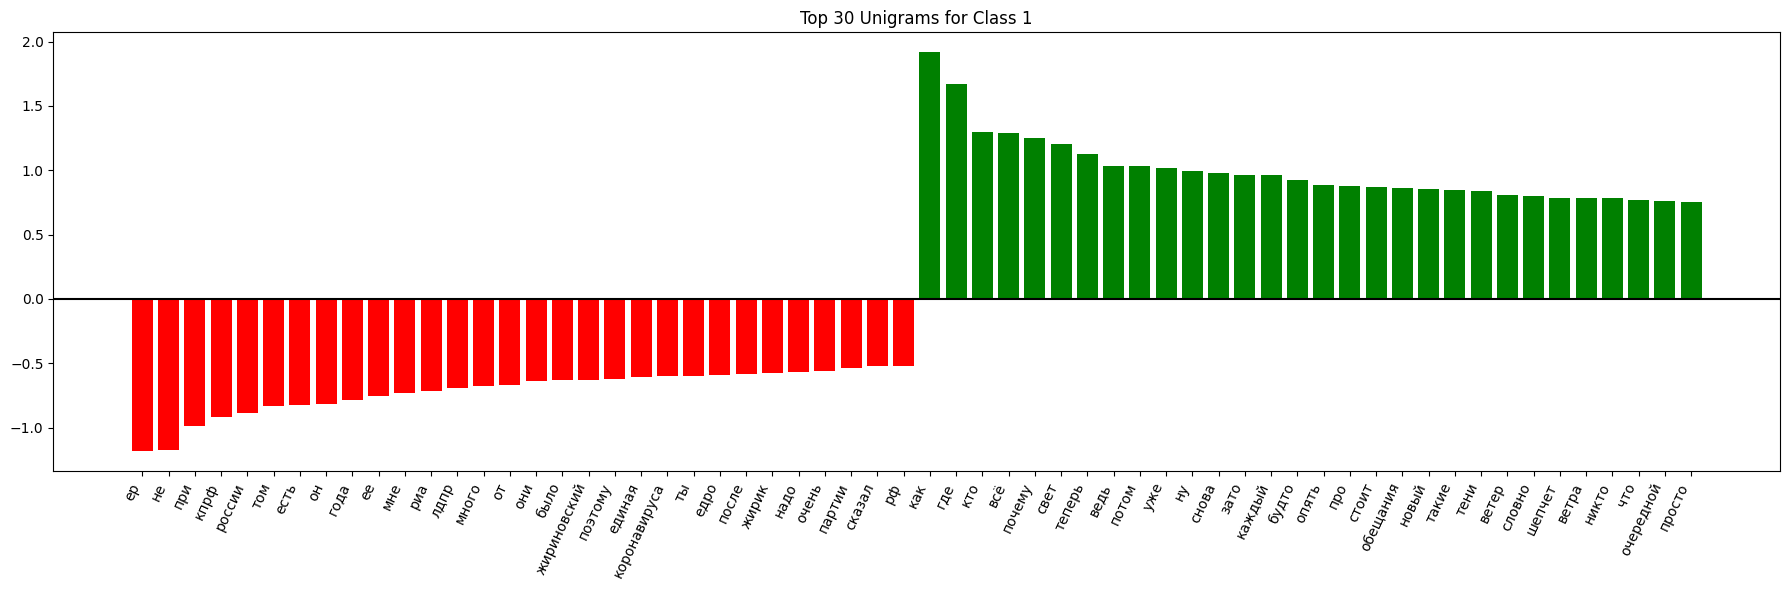

In [199]:
plot_class_unigrams(ai_words, human_words, top_n=30)

### Linear SVM

In [160]:
vect = TfidfVectorizer()
t_scaler = MaxAbsScaler()
svm_linear = LinearSVC()

pipeline_3 = Pipeline([
    ('tfidf', vect),
    ('scaler', t_scaler),
    ('clf', svm_linear)
])

pipeline_3.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('scaler', MaxAbsScaler()),
                ('clf', LinearSVC())])

#### Set up N1

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       297
           1       0.92      0.93      0.93       303

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



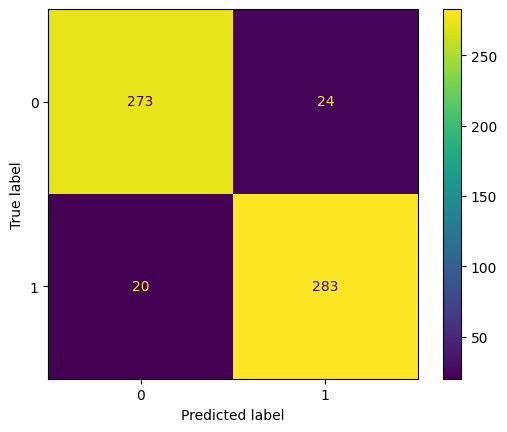

In [161]:
# on test split n1
y_linear_svm_pred_1 = pipeline_3.predict(X_test_1)

print(classification_report(y_test_1, y_linear_svm_pred_1))
ConfusionMatrixDisplay.from_predictions(y_test_1, y_linear_svm_pred_1);

GridSearch

In [162]:
# This cell takes about 6 min to execute!
# Let's try to improve this model
param_grid = {
    'tfidf__analyzer': ['word', 'char'],
    'tfidf__ngram_range': [(1, 1), (2, 4), (3, 5)],
    'clf__C': [0.1, 1, 10]
}

gs_linear_svm = GridSearchCV(pipeline_3, param_grid, cv=5, scoring='f1_macro', verbose=2, n_jobs=-1)
gs_linear_svm.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('scaler', MaxAbsScaler()),
                                       ('clf', LinearSVC())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'tfidf__analyzer': ['word', 'char'],
                         'tfidf__ngram_range': [(1, 1), (2, 4), (3, 5)]},
             scoring='f1_macro', verbose=2)

In [163]:
print("Best parameters:", gs_linear_svm.best_params_)
print("Best F1 score:", gs_linear_svm.best_score_)

Best parameters: {'clf__C': 1, 'tfidf__analyzer': 'char', 'tfidf__ngram_range': (2, 4)}
Best F1 score: 0.937263258957109


              precision    recall  f1-score   support

           0       0.96      0.99      0.98       297
           1       0.99      0.96      0.97       303

    accuracy                           0.97       600
   macro avg       0.98      0.98      0.97       600
weighted avg       0.98      0.97      0.97       600



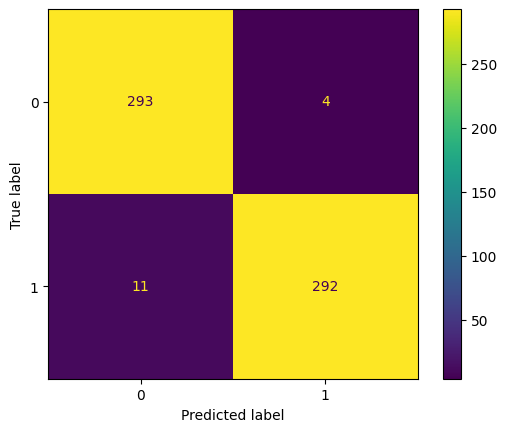

In [164]:
# The result is comparable with the one from LR
y_pred_gs_linear_1 = gs_linear_svm.predict(X_test_1)

print(classification_report(y_test_1, y_pred_gs_linear_1))
ConfusionMatrixDisplay.from_predictions(y_test_1, y_pred_gs_linear_1);

# Save to file
plt.savefig("plots/confusion_matrix_setup_1_svm.png", dpi=300, bbox_inches='tight')

In [165]:
df_errors_linear_svm_1 = get_error_df(df_test_1, y_test_1, y_pred_gs_linear_1)

In [166]:
df_errors_linear_svm_1['genre'].value_counts()

,count
genre,
social,14
news,1


In [167]:
df_errors_linear_svm_1[df_errors_linear_svm_1['genre'] == 'news'].head()

,texts,source,word_counts,genre,class,predicted_label
345,"Не «сука», а «самка собаки»\nФинская компания ...",meduza.io,177.0,news,0,1


In [168]:
# Save to file (test split 1)
df_errors_linear_svm_1.to_csv("data/errors_setup_1_best_svm.csv", index=False)

#### Set up N2

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       297
           1       0.99      0.96      0.97       303

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



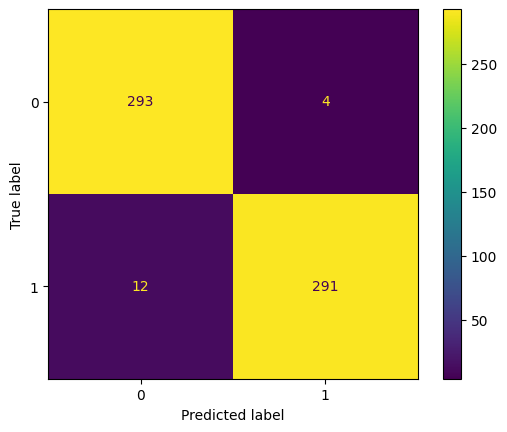

In [169]:
y_pred_gs_linear_2 = gs_linear_svm.predict(X_test_2)

print(classification_report(y_test_2, y_pred_gs_linear_2))
ConfusionMatrixDisplay.from_predictions(y_test_2, y_pred_gs_linear_2);

# Save to file
plt.savefig("plots/confusion_matrix_setup_2_svm.png", dpi=300, bbox_inches='tight')

In [170]:
df_errors_linear_svm_2 = get_error_df(df_test_2, y_test_2, y_pred_gs_linear_2)

In [171]:
df_errors_linear_svm_2['genre'].value_counts()

,count
genre,
social,14
news,2


In [172]:
# One 'mixed' texts were classified as human
df_errors_linear_svm_2[df_errors_linear_svm_2['genre'] == 'news'].head()

,texts,source,word_counts,genre,class,predicted_label
345,"Не «сука», а «самка собаки»\nФинская компания ...",meduza.io,177.0,news,0,1
358,Алексей Навальный выписан из больницы после от...,mixed,NaN,news,1,0


In [173]:
# Save to file (test split 2)
df_errors_linear_svm_2.to_csv("data/errors_setup_2_best_svm.csv", index=False)

#### SVM (Linear) Coefficients Explanation

In [174]:
# Let's check on the best model

# Access the best estimator from GridSearchCV
best_pipeline = gs_linear_svm.best_estimator_

features = best_pipeline.named_steps['tfidf'].get_feature_names_out()
clf = best_pipeline.named_steps['clf']
classes = clf.classes_
coefficients = clf.coef_

# The best model used analyzer 'char', so this will not be helpful
print(f"Classes: {classes}")
print(f"Number of features: {len(features)}")
print(f"Sample features: {features[:20]}")
print(f"Coefficient shape: {coefficients.shape}")

Classes: [0 1]
Number of features: 132092
Sample features: ['\n"' '\n"-' '\n"-д' '\n"ж' '\n"жи' '\n"р' '\n"ро' '\n"с' '\n"ск' '\n('
 '\n(6' '\n(6 ' '\n(в' '\n(в ' '\n(вз' '\n(г' '\n(го' '\n(д' '\n(дв'
 '\n(ду']
Coefficient shape: (1, 132092)


In [175]:
for i, class_i in enumerate(classes):
    if len(classes) == 2 and i == 1:
        coef = clf.coef_[0]
    else:
        coef = -clf.coef_[0]

    print(f'\nClass {class_i}')
    top_positive_indices = np.argsort(coef)[-60:]
    top_negative_indices = np.argsort(coef)[:60]

    print('Top positive features:')
    print(features[top_positive_indices][::-1])
    print('Top negative features:')
    print(features[top_negative_indices])


Class 0
Top positive features:
[',\n' ' е' '\nи' '\nс' '.\n' '\nп' '\nв' ' ер' ' -' 'ири' '\nи ' '", -'
 ' - ' 'е ' ' (' 'не ' ' ед' '\nм' 'не' '\nк' ' он' ' не' '…\n' '\nн'
 'един' '- ' 'ов ' ', - ' ', -' 'о по' 'в то' 'при ' 'с ' ' от' '\nо' 'и '
 'в ' 'жири' 'жир' 'оро' ' и ' 'кп' ') ' 'при' 'бо' ',\nк' '..' ' жир'
 'н ' 'рф' 'они' ' еди' '\nч' ' кп' '.\nс' 'а е' 'зал' 'е н' '\nз' ' риа']
Top negative features:
[', ' '. ' ' а ' ' ш' ', а ' ', чт' ', а' ': ' ', ч' 'а. ' ' но' ' под'
 'кто' '. «' 'чер' 'й. ' '. н' ', к' '. о' 'т, ' ' нов' 'а у' ' у' '. ну'
 'чере' 'а де' 'ечн' '? ' 'жит' 'овы' ' но ' 'т, п' 'жить' 'све' ' где'
 'под' '», ' '-то ' ', ка' 'лож' 'зато' '. од' '»,' 'дь ' 'кт' ' ста'
 ': "' '-т' ' тол' 'я, ' ' вет' 'ь ра' 'свет' ', но' '-то' 'бсу' ' а н'
 'очем' 'таки' 'новы']

Class 1
Top positive features:
[', ' '. ' ' а ' ' ш' ', а ' ', чт' ', а' ': ' ', ч' 'а. ' ' но' ' под'
 'кто' '. «' 'чер' 'й. ' '. н' ', к' '. о' 'т, ' ' нов' 'а у' ' у' '. ну'
 'чере' 'а де' 'ечн'

In [176]:
# Let's check the unigrams from the model before the GridSearch

# Access the steps directly
features = pipeline_3.named_steps['tfidf'].get_feature_names_out()
clf = pipeline_3.named_steps['clf']
classes = clf.classes_
coefficients = clf.coef_

print(f"Classes: {classes}")
print(f"Number of features: {len(features)}")
print(f"Sample features: {features[:20]}")
print(f"Coefficient shape: {coefficients.shape}")

Classes: [0 1]
Number of features: 53477
Sample features: ['00' '000' '005' '01' '02' '023' '028' '03' '031' '04' '043' '05' '055'
 '058' '06' '065' '07' '08' '09' '10']
Coefficient shape: (1, 53477)


In [177]:
for i, class_i in enumerate(classes):
    if len(classes) == 2 and i == 1:
        coef = clf.coef_[0]
    else:
        coef = -clf.coef_[0]

    print(f'\nClass {class_i}')
    top_positive_indices = np.argsort(coef)[-60:]
    top_negative_indices = np.argsort(coef)[:60]

    print('Top positive features:')
    print(features[top_positive_indices][::-1])
    print('Top negative features:')
    print(features[top_negative_indices])


Class 0
Top positive features:
['ер' 'не' 'кпрф' 'россии' 'при' 'лдпр' 'есть' 'он' 'едро' 'жириновский'
 'жирик' 'том' 'единая' 'много' 'поэтому' 'именно' 'ее' 'мне' 'было' 'они'
 'надо' 'парнас' 'года' 'россию' 'от' 'очень' 'жирика' 'владимир' 'того'
 'путин' 'тролль' 'долбоёб' 'вольфович' 'первый' 'ты' 'дмитрий' 'пенсион'
 'жириновским' 'единой' 'выше' 'почти' 'во' 'единую' 'работает' 'рф'
 'сказал' 'риа' 'после' 'довольно' 'ль' 'большое' 'тебя' 'большинство'
 'депутаты' 'кем' 'партию' 'вас' 'аватарку' 'маразм' 'поменять']
Top negative features:
['как' 'почему' 'где' 'кто' 'картинку' 'приложить' 'никто' 'чайник'
 'потом' 'могли' 'ведь' 'теперь' 'снова' '1800' 'подсветкой' 'вт' 'стоит'
 'всё' 'каждый' 'свет' 'зато' 'цирк' 'опять' 'ну' 'обещания' 'кажется'
 'такие' 'будто' 'про' 'хоть' 'новый' 'лица' 'наших' 'шашлыка'
 'достоевского' 'новосиба' 'фанат' 'лосося' 'вчера' 'магазин' 'ветер'
 'очередной' 'уже' 'толку' 'чтобы' 'итоге' 'или' 'словно' 'уровень'
 'просто' 'недавно' 'шепчет' 'ч

In [178]:
# Plot

def plot_coefficients(clf, classes, features, top_features=30):
    for i, class_i in enumerate(classes):
        if len(classes) == 2 and i == 1:
            coef = clf.coef_[0]
        else:
            coef = -clf.coef_[0]

        print(f'\nClass {class_i}')
        top_positive = np.argsort(coef)[-top_features:]
        top_negative = np.argsort(coef)[:top_features]
        top_coefficients = np.hstack([top_negative, top_positive])

        plt.figure(figsize=(12, 5))
        colors = ['red' if c < 0 else 'green' for c in coef[top_coefficients]]
        plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
        plt.xticks(np.arange(1, 1 + 2 * top_features), np.array(features)[top_coefficients],
                   rotation=60, ha='right')
        plt.title(f"Top features for class {class_i}")
        plt.tight_layout()
        plt.show()


Class 0


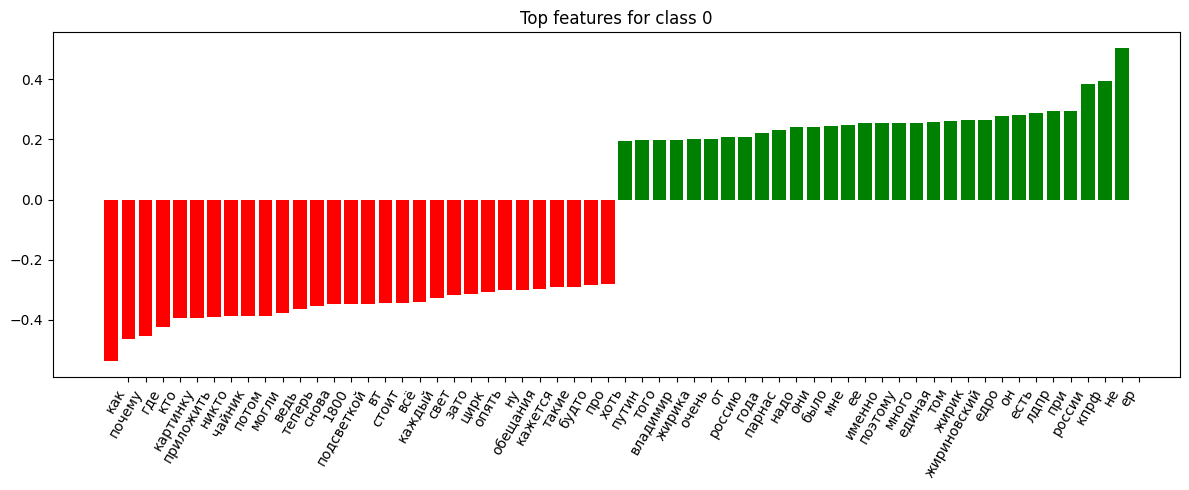


Class 1


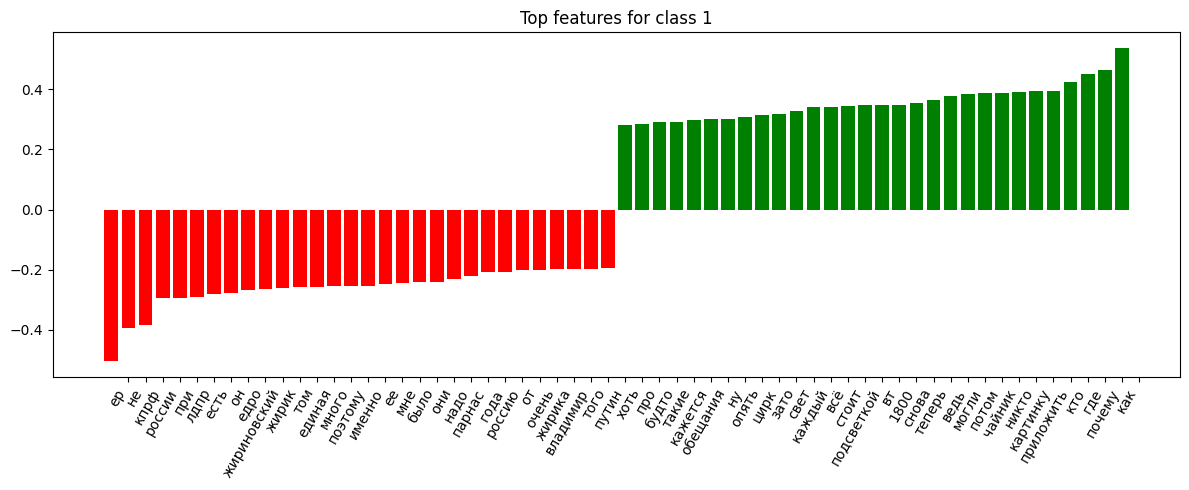

In [179]:
# The words are very similar to those obtained from LR
plot_coefficients(clf, classes, features)

### Set up N3

Let's test the two best models on the third test split where half of the news articles were 'humanized' with Decopy AI and the other half was edited with the focus on n_grams.

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       297
           1       0.99      0.95      0.97       303

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



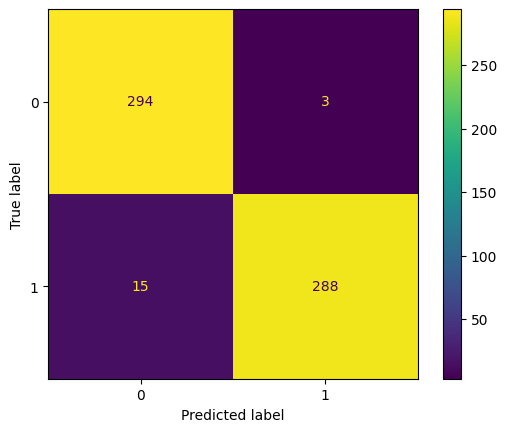

In [180]:
# Best LR model on test split n3
y_gs_pred_3 = gs.predict(X_test_3)

print(classification_report(y_test_3, y_gs_pred_3))
ConfusionMatrixDisplay.from_predictions(y_test_3, y_gs_pred_3);

# Save to file
plt.savefig("plots/confusion_matrix_setup_3_lg.png", dpi=300, bbox_inches='tight')

In [181]:
df_errors_3 = get_error_df(df_test_3, y_test_3, y_gs_pred_3)

In [182]:
df_errors_3['genre'].value_counts()

,count
genre,
social,15
news,3


In [183]:
news_rows_3 = df_errors_3[df_errors_3['genre'] == 'news']
news_rows_3.head()

,texts,source,word_counts,genre,class,predicted_label
94,"Дмитрий Песков, пресс-секретарь президента Рос...",decopy-ai,NaN,news,1,0
366,Оппозиционер Алексей Навальный выписан из боль...,n_grams,NaN,news,1,0
560,Пандемия спровоцировала рост интереса к домашн...,n_grams,NaN,news,1,0


In [184]:
# Save to file (test split 3).
df_errors_3.to_csv("data/errors_setup_3_lg.csv", index=False)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       297
           1       0.99      0.95      0.97       303

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



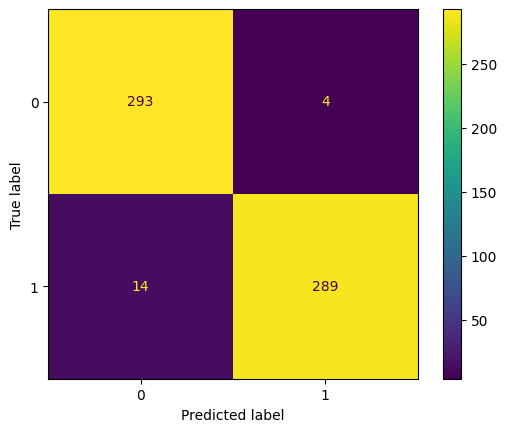

In [185]:
# Best Linear SVM on test n3

y_pred_gs_linear_3 = gs_linear_svm.predict(X_test_3)

print(classification_report(y_test_3, y_pred_gs_linear_3))
ConfusionMatrixDisplay.from_predictions(y_test_3, y_pred_gs_linear_3);

# Save to file
plt.savefig("plots/confusion_matrix_setup_3_svm.png", dpi=300, bbox_inches='tight')

In [186]:
df_errors_linear_svm_3 = get_error_df(df_test_3, y_test_3, y_pred_gs_linear_3)

In [187]:
df_errors_linear_svm_3['genre'].value_counts()

,count
genre,
social,14
news,4


In [188]:
df_errors_linear_svm_3_news = df_errors_linear_svm_3[df_errors_linear_svm_3['genre'] == 'news']
df_errors_linear_svm_3_news.head()

,texts,source,word_counts,genre,class,predicted_label
94,"Дмитрий Песков, пресс-секретарь президента Рос...",decopy-ai,NaN,news,1,0
344,"Не «сука», а «самка собаки»\nФинская компания ...",meduza.io,177.0,news,0,1
366,Оппозиционер Алексей Навальный выписан из боль...,n_grams,NaN,news,1,0
560,Пандемия спровоцировала рост интереса к домашн...,n_grams,NaN,news,1,0


In [189]:
# Save to file (test split 3)
df_errors_linear_svm_3.to_csv("data/errors_setup_3_best_svm.csv", index=False)

## Error Analysis

### LR

In [190]:
# Load the errors datasets

df_errors_1 = pd.read_csv('data/errors_setup_1_lg.csv')
df_errors_2 = pd.read_csv('data/errors_setup_2_lg.csv')
df_errors_3 = pd.read_csv('data/errors_setup_3_lg.csv')

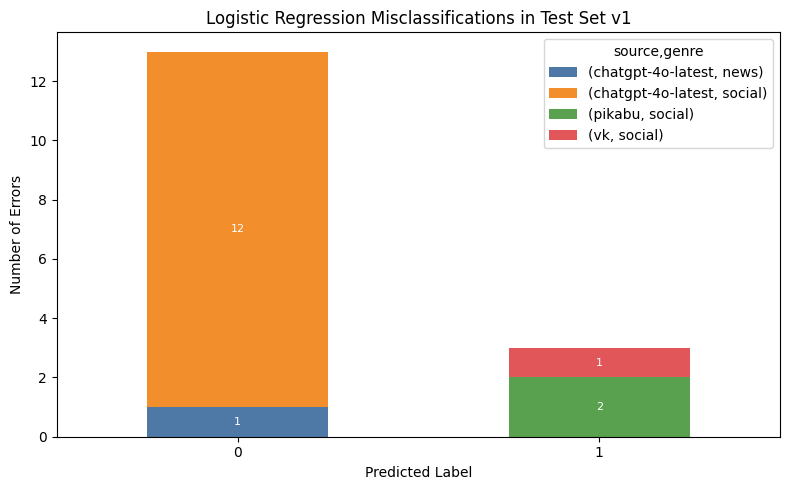

In [191]:
# Plot errors for Test Set v.1
error_counts = df_errors_1.groupby(['predicted_label', 'source', 'genre']).size().reset_index(name='count')

stacked_data = error_counts.pivot_table(
    index='predicted_label',
    columns=['source', 'genre'],
    values='count',
    fill_value=0
)

custom_palette = ['#4E79A7', '#F28E2B', '#59A14F', '#E15759', '#B07AA1']

# Plot stacked bar chart
ax = stacked_data.plot(kind='bar', stacked=True, figsize=(8, 5), color=custom_palette)

# Add count labels — only for non-zero bars
for container in ax.containers:
    labels = [f'{int(bar.get_height())}' if bar.get_height() > 0 else '' for bar in container]
    ax.bar_label(container, labels=labels, label_type='center', fontsize=8, color='white')

plt.title("Logistic Regression Misclassifications in Test Set v1")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Errors")
plt.xticks(rotation=0)
plt.tight_layout()

# Save to file
plt.savefig("plots/lg_misclassifications_setup_1.png", dpi=300, bbox_inches='tight')
plt.show()

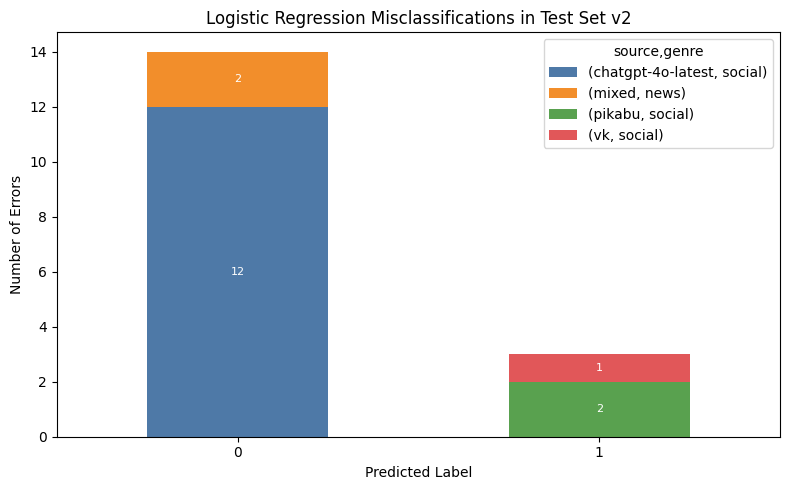

In [192]:
# Plot errors for Test Set v.2
error_counts = df_errors_2.groupby(['predicted_label', 'source', 'genre']).size().reset_index(name='count')

stacked_data = error_counts.pivot_table(
    index='predicted_label',
    columns=['source', 'genre'],
    values='count',
    fill_value=0
)

ax = stacked_data.plot(kind='bar', stacked=True, figsize=(8, 5), color=custom_palette)

for container in ax.containers:
    labels = [f'{int(bar.get_height())}' if bar.get_height() > 0 else '' for bar in container]
    ax.bar_label(container, labels=labels, label_type='center', fontsize=8, color='white')

plt.title("Logistic Regression Misclassifications in Test Set v2")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Errors")
plt.xticks(rotation=0)
plt.tight_layout()

# Save to file
plt.savefig("plots/lg_misclassifications_setup_2.png", dpi=300, bbox_inches='tight')
plt.show()

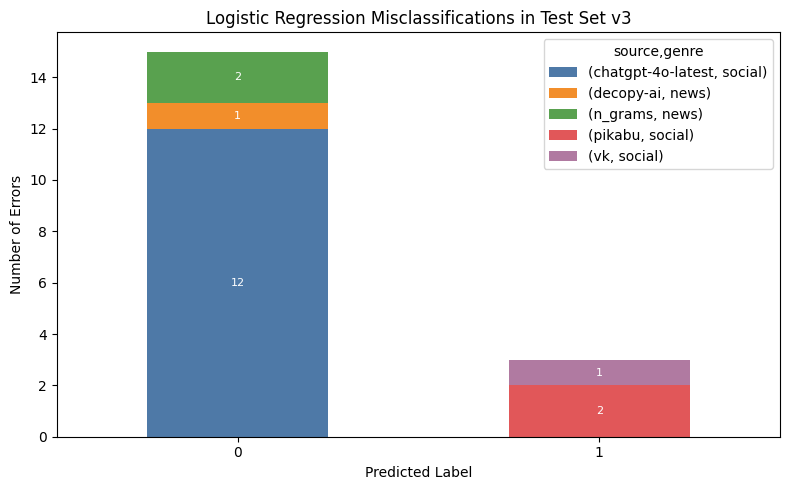

In [193]:
# Plot errors for Test Set v.3
error_counts = df_errors_3.groupby(['predicted_label', 'source', 'genre']).size().reset_index(name='count')

stacked_data = error_counts.pivot_table(
    index='predicted_label',
    columns=['source', 'genre'],
    values='count',
    fill_value=0
)

ax = stacked_data.plot(kind='bar', stacked=True, figsize=(8, 5), color=custom_palette)

for container in ax.containers:
    labels = [f'{int(bar.get_height())}' if bar.get_height() > 0 else '' for bar in container]
    ax.bar_label(container, labels=labels, label_type='center', fontsize=8, color='white')

plt.title("Logistic Regression Misclassifications in Test Set v3")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Errors")
plt.xticks(rotation=0)
plt.tight_layout()

# Save to file
plt.savefig("plots/lg_misclassifications_setup_3.png", dpi=300, bbox_inches='tight')
plt.show()

### Linear SVM

In [194]:
# Load the errors datasets

df_errors_linear_svm_1 = pd.read_csv('data/errors_setup_1_best_svm.csv')
df_errors_linear_svm_2 = pd.read_csv('data/errors_setup_2_best_svm.csv')
df_errors_linear_svm_3 = pd.read_csv('data/errors_setup_3_best_svm.csv')

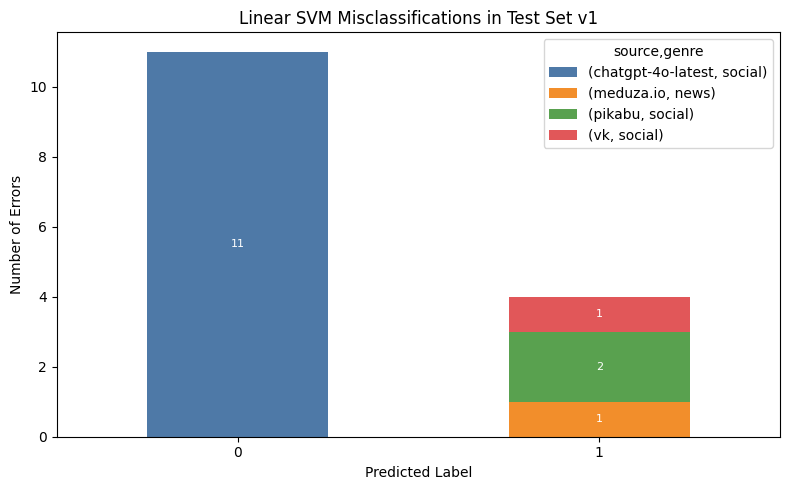

In [195]:
# Plot errors for Test Set v.1
error_counts = df_errors_linear_svm_1.groupby(['predicted_label', 'source', 'genre']).size().reset_index(name='count')

stacked_data = error_counts.pivot_table(
    index='predicted_label',
    columns=['source', 'genre'],
    values='count',
    fill_value=0
)

ax = stacked_data.plot(kind='bar', stacked=True, figsize=(8, 5), color=custom_palette)

for container in ax.containers:
    labels = [f'{int(bar.get_height())}' if bar.get_height() > 0 else '' for bar in container]
    ax.bar_label(container, labels=labels, label_type='center', fontsize=8, color='white')

plt.title("Linear SVM Misclassifications in Test Set v1")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Errors")
plt.xticks(rotation=0)
plt.tight_layout()

# Save to file
plt.savefig("plots/linear_svm_misclassifications_setup_1.png", dpi=300, bbox_inches='tight')
plt.show()

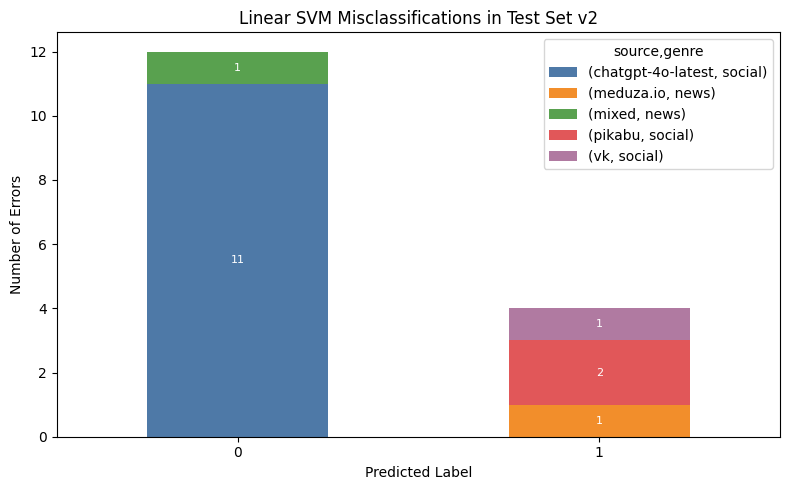

In [196]:
# Plot errors for Test Set v.2
error_counts = df_errors_linear_svm_2.groupby(['predicted_label', 'source', 'genre']).size().reset_index(name='count')

stacked_data = error_counts.pivot_table(
    index='predicted_label',
    columns=['source', 'genre'],
    values='count',
    fill_value=0
)

ax = stacked_data.plot(kind='bar', stacked=True, figsize=(8, 5), color=custom_palette)

for container in ax.containers:
    labels = [f'{int(bar.get_height())}' if bar.get_height() > 0 else '' for bar in container]
    ax.bar_label(container, labels=labels, label_type='center', fontsize=8, color='white')

plt.title("Linear SVM Misclassifications in Test Set v2")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Errors")
plt.xticks(rotation=0)
plt.tight_layout()

# Save to file
plt.savefig("plots/linear_svm_misclassifications_setup_2.png", dpi=300, bbox_inches='tight')
plt.show()

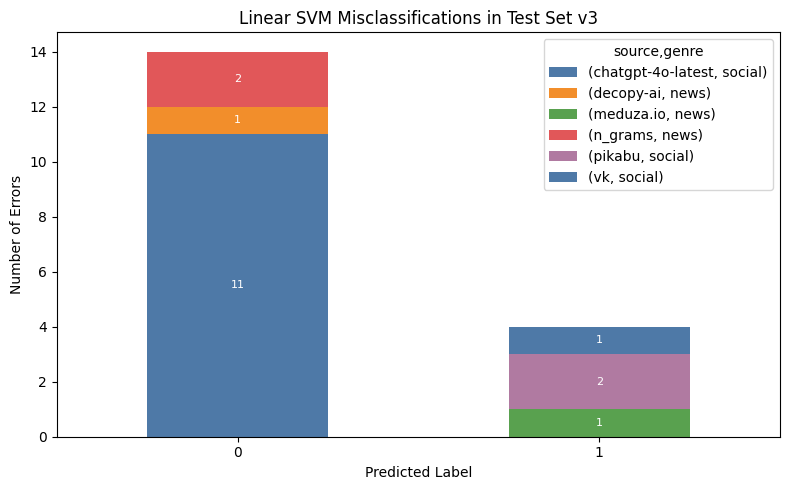

In [197]:
# Plot errors for Test Set v.3
error_counts = df_errors_linear_svm_3.groupby(['predicted_label', 'source', 'genre']).size().reset_index(name='count')

stacked_data = error_counts.pivot_table(
    index='predicted_label',
    columns=['source', 'genre'],
    values='count',
    fill_value=0
)

ax = stacked_data.plot(kind='bar', stacked=True, figsize=(8, 5), color=custom_palette)

for container in ax.containers:
    labels = [f'{int(bar.get_height())}' if bar.get_height() > 0 else '' for bar in container]
    ax.bar_label(container, labels=labels, label_type='center', fontsize=8, color='white')

plt.title("Linear SVM Misclassifications in Test Set v3")
plt.xlabel("Predicted Label")
plt.ylabel("Number of Errors")
plt.xticks(rotation=0)
plt.tight_layout()

# Save to file
plt.savefig("plots/linear_svm_misclassifications_setup_3.png", dpi=300, bbox_inches='tight')
plt.show()